# Module 6: CFA
# Use Case: Credit Risk - Identifying Bad Credit Risks
# ===========================================

In this example, we aim to predict bad consumer credits, and we develop a classification model for this purpose, driven by loan and debtor attributes. We would use this model to accept or reject a customer’s business.

Dataset: Credit risk https://datahub.io/machine-learning/credit-g
Dua, D. and Graff, C. (2019). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.

In [1]:
# package for working with tabular data
import pandas as pd 
import numpy as np

# Package for charting
import matplotlib.pyplot as plt
import seaborn as sns #charts

# package for timing runtime
import time

# package for navigating the operating system
import os

## Utilities: Governance and Fairness

First we will declare and introduce the functions we will be using to implement the Governance Framework, and principles of Fairness in our process.




### Governance Framework Functions

@@@@@@@@@@@@@@ AUGUSTINE! DECLARE ALL YOUR FUNCTIONS HERE ... WE CAN LATER DECIDE IF WE PACKAGE UP

### Stakeholder KPIs


In Stage1, Business Analysis, we will find that we have several stakeholders for the model. We need analytics and visualizations to verify that we are attaining good performance on each stakeholder's key performance indicators (KPI) We list the stakeholder governance functions we will use as utilities in this case study now...

In [2]:
# ROC Curve to visualize classifier accuracy.
import sklearn.metrics as metrics

# Performance metrics...
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

# Analyst KPI: ROC Curve, f1, precision and accuracy of y_hat from a classifier
# Compute micro-average ROC curve and ROC area
def kpi_review_analyst(mdl: object,
                       X: np.array, 
                       y: np.array,
                       y_hat: np.array) -> (float, float, float):

  #sanity
  if X.shape[0] != y_test.shape[0]:
    raise TypeError('Bad parameter: X.shape[0] != y_test.shape[0]')
  if y.shape[0] != y_hat.shape[0]:
    raise TypeError('Bad parameter: y_test.shape[0] != y_test_hat.shape[0]')
  if (y.dtype != y_hat.dtype):
    raise TypeError('Bad parameter: y_test.dtypes != y_test_hat.dtypes')

  # F1, precision, recall...  
  prec = precision_score(y_true=y[:], y_pred=y_hat[:])
  rec = recall_score(y_true=y[:], y_pred=y_hat[:])
  f1 = f1_score(y_true=y[:], y_pred=y_hat[:])

  print(prec)

  # ROC Curve
  metrics.plot_roc_curve(mdl, X, y) 
  fpr, tpr, thresholds = metrics.roc_curve(y, y_hat)
  roc_auc = metrics.auc(fpr, tpr)
  display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                    estimator_name='example estimator')
  display.plot()
  plt.show()

  return f1, prec, rec


### Fairness Functions

@@@@@@@@@@@@@@ MADHU! DECLARE ALL YOUR FUNCTIONS HERE ... WE CAN LATER DECIDE IF WE PACKAGE UP

In [25]:
#Added by Madhu
from sklearn.metrics import confusion_matrix
def x_metrics(true_label, predicted_label):
    #This module computes the confusion matrix columns
    TN, FP, FN, TP = confusion_matrix(true_label, predicted_label, labels = [0,1]).ravel()
    return TN, FP, FN, TP

def trainModel(X_train, y_train):
    rf1 = RandomForestClassifier(max_depth=5,random_state=0)
    rf1.fit(X_train,y_train)
    return rf1

def predictModel(model, X_test, threshold=0.5):
    y_pred_proba = model.predict_proba(X_test)
    return (y_pred_proba[:,0] < threshold).astype('int')

def getFairnessRatios(y_test, y_pred):
    TN, FP, FN, TP = x_metrics(y_test, y_pred)
    accuracy = (TP + TN)/(TP+TN+FP+FN)
    fnr = FN/(FN+TP)
    fdr = FP/(FP+TP)
    fpr = FP/(FP+TN)
    npv = TN/(TN+FN)
    recall = TP/(TP+FN)
    precision = TP/(TP+FP)
    return pd.Series({'Stats': '', 'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'fnr': fnr, 'fdr': fdr, 'fpr': fpr, 'npv': npv})


This module *getFairnessStats* generates the fairness test stats, for each of the population groups. The inputs are:
* aCategory: The population group to be tested, e.g. gender
* catList: List of possible values for the category e.g. Male, Female

The output from this module is a dataframe with the precision, recall etc metrics, for each of the population groups



In [38]:
#Added by Madhu
def getFairnessStats (aModel, aCategory, catList, X_test, y_test, threshold):
    anIndex=0
    y_testS = []
    y_pred = []
    X_testS = []
    modelStats = []
    statsDF = pd.DataFrame(columns=['Stats'])
    for catG in catList:
        #Create category specific test data - i.e. Male and Female test data
        X_testS.append( X_test[(X_test[aCategory] == catG)])
        X_testS[anIndex] = X_testS[anIndex].drop(aCategory, axis=1)
        
        y_testS.append(y_test[(y_test[aCategory] == catG)])
        y_testS[anIndex] = y_testS[anIndex].drop(aCategory, axis=1)
        
        y_pred.append( predictModel(model, X_testS[anIndex], threshold))
        modelStats.append(getFairnessRatios(y_testS[anIndex], y_pred[anIndex]))
        
        modelStats[anIndex].update({'Stats': catG})
        statsDF = pd.concat([statsDF, pd.DataFrame([modelStats[anIndex]], columns=modelStats[anIndex].index)]).reset_index(drop=True)
        anIndex+=1
    return statsDF

This module *testForFairness* plots a bar chart with the appropriate metric, for each of the population groups. The inputs are:
* fairnessTestItems: The population groups to be tested, e.g. gender
* majorityCategories: List of majority population group name e.g. Male
* compareMetrics: which fairness metric to compare across population groups. e.g. Precision

The output from this module is a dataframe with the precision, recall etc metrics, for each of the population groups

In [39]:
#Added by Madhu
def testForFairness (aModel, fairnessTestItems, majorityCategories, compareMetrics = ["Precision"], threshold=0.8, rangePercent = 0.2):
    fig, axs = plt.subplots(len(compareMetrics), len(fairnessTestItems))
    for anIndex in range(len(fairnessTestItems)):
        aCategory = fairnessTestItems[anIndex]
        catList = X_test[aCategory].unique().tolist()
        majorityClass = majorityCategories[anIndex]
        xxx = fairnessTestItems.copy()
        xxx.remove(aCategory)
        X_test_FT = X_test.drop(xxx, axis=1)
        y_test_FT = y_test.drop(xxx, axis=1)
        statsDF = getFairnessStats (aModel, aCategory, catList, X_test_FT, y_test_FT, threshold)
        #Now plot the fairness charts
        X_val = statsDF["Stats"].values.tolist()
        aMetricIndex = 0
        for aMetric in compareMetrics: 
            majRange = statsDF.loc[statsDF["Stats"] == majorityClass, aMetric].astype('float64').values[0]
            Y_val = statsDF[aMetric].values.tolist()
            axs[aMetricIndex, anIndex].bar(X_val, Y_val)
            axs[aMetricIndex, anIndex].set_title( "At Threshold " + str(threshold))
            axs[aMetricIndex, anIndex].set_ylim(0,1)
            axs[aMetricIndex, anIndex].set_ylabel(aMetric)
            axs[aMetricIndex, anIndex].axhline(y=majRange*(1-rangePercent),color='red')
            axs[aMetricIndex, anIndex].axhline(y=majRange,color='green')
            axs[aMetricIndex, anIndex].axhline(y=majRange*(1+rangePercent),color='red')
            plt.subplots_adjust(hspace=1)
            aMetricIndex += 1
    fig.tight_layout()

# Stage1. Business Case 

Define key performance indicators (KPIs). 
Data needed, outcomes, model risk level, communication strategy.
Regulatory and Compliance issues 

Limitations of the models

Assumptions made by the models

Restrictions of the models...

@@@@@@@@@@@@@@@@@@@@@ MADHU ARE YOU OK DEFINING KPIs HERE? 1) ACCURACY? 2) FAIRNESS


# Stage2. Data

Next we load the data we need to achieve our business aims, wrangle it and prepare it.

##Stage2a. Load Data

If this is running in Google Colab.... we extract the GitHub loc where the data resides....

In [438]:
!git clone https://github.com/danphilps/credit_use_case

Cloning into 'credit_use_case'...
remote: Enumerating objects: 115, done.
remote: Counting objects: 100% (115/115), done.
remote: Compressing objects: 100% (109/109), done.
remote: Total 115 (delta 49), reused 19 (delta 3), pack-reused 0
Receiving objects: 100% (115/115), 18.49 MiB | 10.16 MiB/s, done.
Resolving deltas: 100% (49/49), done.


In [439]:
# We should see a "credit_use_case" directory....
os.listdir()

['Ch20_AutoML.ipynb',
 'Bkup',
 'credit_use_case',
 'credit-g.csv',
 'M6_Credit',
 '.gitattributes',
 'M6_Credit_BAK.ipynb',
 'README.md',
 '.git',
 'M6_Credit.ipynb']

In [440]:
os.chdir('credit_use_case')

In [3]:
loc = "credit-g.csv"
df_raw = pd.read_csv(loc)

In [442]:
df_raw.columns

Index(['checking_status', 'duration', 'credit_history', 'purpose',
       'credit_amount', 'savings_status', 'employment',
       'installment_commitment', 'personal_status', 'other_parties',
       'residence_since', 'property_magnitude', 'age', 'other_payment_plans',
       'housing', 'existing_credits', 'job', 'num_dependents', 'own_telephone',
       'foreign_worker', 'class'],
      dtype='object')

#### Bias Alert: Protected and Privileged Groups...

Loan approval is a high risk application. We need to go very carefully as a result. We need to identify any protected characteristics (ie it would be illegal to differentiate based on these) present in the dataset. 
Our use-case is a loan approval use case, ethnicity and gender are protected charcteristics where biases would be illegal. We clearly need to remove these features.
It is also possible to identify priviledged groups and remove biases based on these characterictics. 


In [4]:
# Protected data items - 'personal_status' has a "sex" classifier - REMOVE!
df = df_raw.drop(columns=['personal_status'])

# Priviledged dataitems - remove all ages < 25
df['age'] = df_raw['age'][lambda x: x >= 25]


In [5]:
# Check for biases on protected characteristics...
df_female = df_raw[(df_raw['personal_status'].str.contains('female') != 0)]
df_male = df_raw[(df_raw['personal_status'].str.contains('female') == 0)]

# % of females 
female_good_credits = df_female[(df_female['class'] == 'good')].shape[0]
female_good_credits_pct = female_good_credits / df_female.shape[0]
#
male_good_credits = df_male[(df_male['class'] == 'good')].shape[0] 
male_good_credits_pct = male_good_credits / df_male.shape[0]

#  Difference in good credits for females and males...
print('Female good credits: ' + str(format(round(female_good_credits_pct*100, 2))) + '%')
print('Male good credits: ' + str(format(round(male_good_credits_pct*100, 2))) + '%')


Female good credits: 64.84%
Male good credits: 72.32%


There is clearly a bias in the dataset, but to expand upon this we can use a Chi2 test to examine whether the observed "bad" credits we see in female rows, is statistically significant to the expected difference we see in male rows.

It is possible that this bias is proxied by another data item in the dataset. **We will come back to this issue later**.

In [6]:
from scipy.stats import chi2_contingency

# Examine gender bias ... Generate  confusion matrix that to examine this bias...
df_raw['gender'] = np.where(df_raw['personal_status'].str.contains('female') == 0, 'female', 'male')
conf_matrix = pd.crosstab(df_raw['gender'], df_raw['class']) 

print('Male/Female Good/Bad Credits Confusion Matrix \n' + str(conf_matrix))

# Chi-square test of independence. 
c, p, dof, expected = chi2_contingency(conf_matrix) 
# Print the p-value
print('\n Chi-square test of independence')
print('p-val of Chi2 test: ' + str(round(p, 4)))

Male/Female Good/Bad Credits Confusion Matrix 
class   bad  good
gender           
female  191   499
male    109   201

 Chi-square test of independence
p-val of Chi2 test: 0.0207


Note that we now have identified 2 classes, male and female, with males priviledged, which means we need to be fair between these two groups 

### Check for proxies of our protected characteristics
 
We noted that there is a bias in our dataset between the protected characterisctis of gender, with male and female credits being different, and we removed this protected characteristic from the dataset to avoid this illegal bias in loan approval outcomes.

Protected characteristics can be picked up (proxied) in other dataitems in more subtle ways though. For instance given that single parent households tend to disproportionately be led by a female adult, this may make 'num_dependents' a proxy for gender.

It is important that we control for any possible protected biases, and one way of achieving this is to retrain our model using a mitigator, which trains by constraining the model weights to produce a balanced outcome between protected classes; male and female credits in this case.

To ascertain proxies we can check the correlation of our protected feature with ther features in the dataset.

Our protected features is categorical, so compare other categorical features with our protected feature we can use a Chi2 test. 
To compare  

In [446]:
# MADHU: FAIRNESS FUNCTION HERE!!

## Stage2b. Data Wrangling and Preprocessing

Data Wrangling: As we have shown in previous chapters we need to convert categorical data into one-hot-encodings, clean characters from numeric data columns, carry out type conversions into numeric datatypes... The following cell shows the appropriate data wrangling to get our data into a good shape. 

In [16]:
# list categorical columns...
cat_cols =['checking_status', 'purpose', 'credit_history', 'savings_status', 'employment', 'other_parties', 'property_magnitude', 'other_payment_plans','housing','job','own_telephone']

# One hot encoding of catagorical variables...
df[cat_cols].astype("category")
one_hot_encodings = pd.get_dummies(df[cat_cols])

#Combine dfs
df = pd.concat([df, one_hot_encodings], axis=1)

#remove categorical columns...
df = df.drop(columns=cat_cols)

#Data wrangling..... get types and bad values sorted out

# Remove characters in numeric columns (note that the data type was set, by the open_csv function to object, 
# so we first convert to string before running the replace function (which can only be fun on str types)
df['foreign_worker'] = df['foreign_worker'].str.replace('yes', '1')
df['foreign_worker'] = df['foreign_worker'].str.replace('no', '0')
df['class'] = df['class'].str.replace('good', '0')
df['class'] = df['class'].str.replace('bad', '1')

# Convert to numerics so we can use in ML... we force type conversions, then print our resulting df.
df['foreign_worker'] = pd.to_numeric(df['foreign_worker'], errors ='coerce').fillna(0).astype('int')
df['class'] = pd.to_numeric(df['class'], errors ='coerce').fillna(0).astype('int')
df['duration'] = pd.to_numeric(df['duration'], errors ='coerce').fillna(0).astype('int')
df['installment_commitment'] = pd.to_numeric(df['installment_commitment'], errors ='coerce').fillna(0).astype('int')
df['residence_since'] = pd.to_numeric(df['residence_since'], errors ='coerce').fillna(0).astype('int')
df['age'] = pd.to_numeric(df['age'], errors ='coerce').fillna(0).astype('int')
df['num_dependents'] = pd.to_numeric(df['num_dependents'], errors ='coerce').fillna(0).astype('int')

df

KeyError: "None of [Index(['checking_status', 'purpose', 'credit_history', 'savings_status',\n       'employment', 'other_parties', 'property_magnitude',\n       'other_payment_plans', 'housing', 'job', 'own_telephone'],\n      dtype='object')] are in the [columns]"

In [17]:
df.columns

Index(['duration', 'credit_amount', 'installment_commitment',
       'residence_since', 'age', 'existing_credits', 'num_dependents',
       'foreign_worker', 'class', 'checking_status_0<=X<200',
       'checking_status_<0', 'checking_status_>=200',
       'checking_status_no checking', 'purpose_business',
       'purpose_domestic appliance', 'purpose_education',
       'purpose_furniture/equipment', 'purpose_new car', 'purpose_other',
       'purpose_radio/tv', 'purpose_repairs', 'purpose_retraining',
       'purpose_used car', 'credit_history_all paid',
       'credit_history_critical/other existing credit',
       'credit_history_delayed previously', 'credit_history_existing paid',
       'credit_history_no credits/all paid', 'savings_status_100<=X<500',
       'savings_status_500<=X<1000', 'savings_status_<100',
       'savings_status_>=1000', 'savings_status_no known savings',
       'employment_1<=X<4', 'employment_4<=X<7', 'employment_<1',
       'employment_>=7', 'employment_une

## Stage2c. Exploratory Data Analysis

Once we have loaded the data and have it in a useable form, we now need to examine it, to build an intuition for the distributions, accuracy, missing values, imbalances and so on.

One major bias, particularly when we are fitting a model to a relatively low probability event, such as a default, are imbalances in the data. By definition our target occurs less than half the time.

#### Bias Alert: Imbalanced dataset

Imbalances in datasets for classification problems are a big issue. We generally need to balance the dataset to contain an equal proportion of the different classes before training (and testing). For the credit use-case, we have two classes {1,0}, meaning that ideally 50% of our samples should be class=1; and 50% class=0. If this is not the case and we have an imbalance (we do), we can balance the data by up-sampling the minority class, or down-sampling the majority class.
Let us first examine the dataset to determine whether it is in balance.

Imbalanced dataset....
0    700
1    300
Name: class, dtype: int64


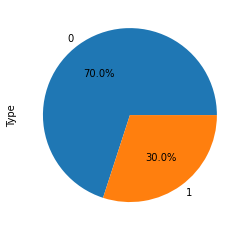

In [449]:

#Pie chart of imbalances wrapped as a func as we will use it a few times..
def pie_of_imbalance(df: pd.DataFrame, class_col: str = 'class'):
    print('Imbalanced dataset....')
    print(df[class_col].value_counts())
    df.groupby(class_col).size().plot(kind='pie', y = 'class', label = "Type",  autopct='%1.1f%%')
    
#run func
pie_of_imbalance(df)

The dataset is not balanced. 70% of samples are class=0; only 30% are class=1. We should bring this into balance before we train our model, or risk introducing dangerous biases into our forecasts.

# Stage3: Model Design 

Now we need to take what we have learned about the data, and find an appropriate model to achieve our KPIs.

## Stage 3a: Test the performance of different up, and down sampling approaches

Before we start up or down-sampling to correct the imbalance, we first we need to create our testing and training datasets. We can then balance the training set. This is to keep the training-set in-sample and the testing-set strictly out-of-sample. There is a risk of data leakage in this process we must consider and contriol for.

#### Bias Alert: Data Leakage 

Separate training and testing datasets BEFORE balancing the dataset is crucial to avoid adta leakage. This is crucial as our learner must not see any of the test samples until we actually test it for performance. If we fail to separate testing and training data before up samplng, we can suffer data-snooping biases (also called data-leakage), which would invalidate our model.

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
# Define X and y variables
cols  = list(df.columns)
cols.remove('class')

# Contains only numerics
X = df[cols]
y = df['class']

#Test and train set    
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=None)

### Stage Test up and down sampling approaches using a Random Forest Classifier
We will use the RandomForest classifier to help us test different up and down sampling approaches to deal with the imbalanced dataset. We will be able to see the relative performance of each balancing approach on our problem.

First let us run the classifier on the imbalanced data and examine the F1 score that results when we test the model. (It is a very poor result).

Get the sklearn packages we will need for our clasification problem

In [452]:
import numpy as np

from sklearn.preprocessing import StandardScaler

# Classifiers
from sklearn.ensemble import RandomForestClassifier

# metrics...
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix

We can wrap training for the Random Forest classifier, and the printing of performance metrics in a function, as we will be running this more than once.

<class 'sklearn.ensemble._forest.RandomForestClassifier'>
Accuracy train: 0.8071, test:  0.7033
Precision train: 0.7898, test:  0.7074
Recall train: 0.9940, test:  0.9502
F1 train: 0.5055, test:  0.3101


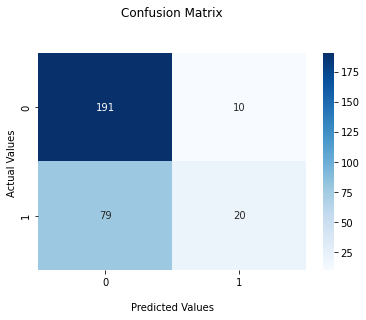

Now use sklearns predict_proba to generate probability values for each prediction


X has feature names, but RandomForestClassifier was fitted without feature names


array([[0.68800386, 0.31199614],
       [0.42447043, 0.57552957],
       [0.47738312, 0.52261688],
       [0.6730528 , 0.3269472 ],
       [0.45821596, 0.54178404],
       [0.45998571, 0.54001429],
       [0.39251133, 0.60748867],
       [0.46070031, 0.53929969],
       [0.56381589, 0.43618411]])

In [453]:
# Declare a function to wrap training of a classifier and printing of performance data
def run_rf_classification_models(X_train: pd.DataFrame, 
                              X_test: pd.DataFrame, 
                            y_train: pd.DataFrame, 
                            y_test: pd.DataFrame) -> object:
    
    #sanity
    if X_train.shape[0] != y_train.shape[0]:
      raise TypeError('Bad parameter: X_train.shape[0] != y_train.shape[0]')
    if X_test.shape[0] != y_test.shape[0]:
      raise TypeError('Bad parameter: X_train.shape[0] != y_train.shape[0]')
    if (X_train.dtypes != X_test.dtypes).sum() != 0:
      raise TypeError('Bad parameter: X_train.dtype != X_test.dtype')
    if (y_train.dtypes != y_test.dtypes):
      raise TypeError('Bad parameter: y_train.dtype != y_test.dtype')

    # Scale and transform the data for training
    sclr = StandardScaler()
    sclr.fit(X_train) # scale to 0 mean and std dev 1 on training data

    X_train = sclr.fit_transform(X_train) # scale both sets:
    X_test = sclr.fit_transform(X_test)

    # classifier train
    rf = RandomForestClassifier(max_depth=5,random_state=0)
    rf.fit(X_train,y_train)
    y_train_hat =rf.predict(X_train)
    y_test_hat = rf.predict(X_test)

    # Print score
    print(type(rf))        
    print(f"Accuracy train: {rf.score(X_train,y_train):.4f}, test: ",
      f"{rf.score(X_test,y_test):.4f}")
    print(f"Precision train: {precision_score(y_train, y_train_hat, average=None)[0]:.4f}, test: ",
      f"{precision_score(y_test,y_test_hat, average=None)[0]:.4f}")
    print(f"Recall train: {recall_score(y_train, y_train_hat, average=None)[0]:.4f}, test: ",
      f"{recall_score(y_test,y_test_hat, average=None)[0]:.4f}")
    print(f"F1 train: {f1_score(y_train, y_train_hat, average=None)[1]:.4f}, test: ",
      f"{f1_score(y_test,y_test_hat, average=None)[1]:.4f}")
    
    #Print confusion matrix...
    cf_matrix = confusion_matrix(y_test, y_test_hat, labels=[0, 1]) 
    cf_matrix_norm = cf_matrix.astype('float') # / cf_matrix.sum(axis=1)[:, np.newaxis]

    ax = sns.heatmap(cf_matrix_norm, annot=True, cmap='Blues', fmt='g')
    ax.set_title('Confusion Matrix\n\n');
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ');
    plt.show()

    #sanity
    if rf is None:
      raise TypeError('Bad return: rf is None')

    return rf

#run our classifier function
mod = run_rf_classification_models(X_train, X_test, y_train, y_test)

print('Now use sklearns predict_proba to generate probability values for each prediction')
mod.predict_proba(X_test)[0:9,:]

### 3a i) Upsampling using resampling

First we test up-sampling using sklearn's resample, and examine how well it does using the RandomForest classifier. Resampling can up-sample by simply randomly selecting and copying existing observations of the minority class. We can balance the classes in this way.

In [454]:
from sklearn.utils import resample

#Split first to avoid data-snooping
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=None)

# Create up-sampled data set for minority class
# note that n_samples= the number of samples the imbalance represents.
X_upsampled, y_upsampled = resample(X_train[y_train == 1],
                                        y_train[y_train == 1],
                                        replace=True,
                                        n_samples=(X_train[y_train == 0].shape[0]-X_train[y_train == 1].shape[0]),
                                        random_state=None)

#Combine train with upsampled
X_upsampled = X_train.append(X_upsampled)
y_upsampled = y_train.append(y_upsampled)

Let us check everything is in balance now

Imbalanced dataset....
0    488
1    488
Name: class, dtype: int64


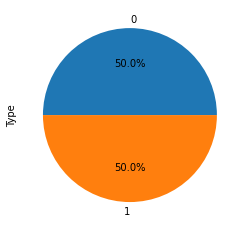

In [455]:
#get pie of the current imbalance
temp = pd.concat([X_upsampled, y_upsampled], axis=1)
pie_of_imbalance(temp)

Dataset is perfectly in balance...

<class 'sklearn.ensemble._forest.RandomForestClassifier'>
Accuracy train: 0.8412, test:  0.7067
Precision train: 0.8776, test:  0.8563
Recall train: 0.7930, test:  0.7028
F1 train: 0.8485, test:  0.5888


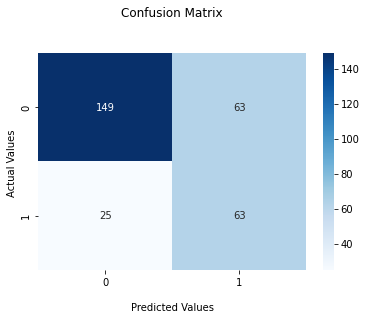

In [456]:
#Run our function....
model = run_rf_classification_models(X_upsampled, X_test, y_upsampled, y_test)

The F1 score on the test data has increased markedly.

### 3a ii) Up-sampling using a synthetic over sampling approach called SMOTE

Add the libraries we will need... and generate the synthetic data to balance our classes using SMOTE.

In [22]:
from imblearn.over_sampling import SMOTE

#How many samples do we need to balance?
idx = np.random.choice(X_train.shape[0], size=X_train[y_train == 0].shape[0]-X_train[y_train == 1].shape[0], replace=False)

# Generate SMOTE samples and use this to train
upsampler_smote = SMOTE()
X_upsampled_smote, y_upsampled_smote = upsampler_smote.fit_resample(X=X_train, y=y_train)

Before we use the up-sampled dataset to train our classifier, let us first examine the distribution of the synthetic datapoints that SMOTE creates

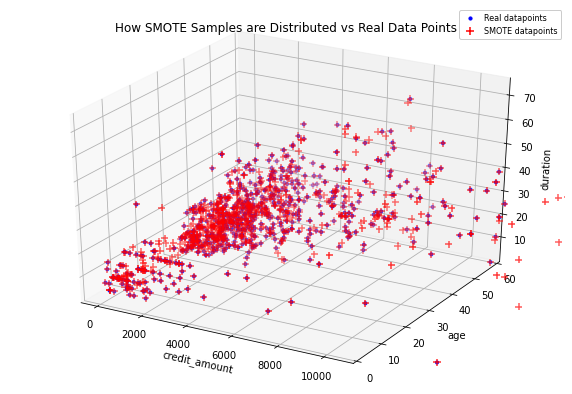

In [458]:
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


fig = plt.figure(figsize=(10, 7)) 
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X_train['credit_amount'],X_train['age'], X_train['duration'], marker="o", s=10, c='blue', label='Real datapoints')
ax.scatter(X_upsampled_smote['credit_amount'],X_upsampled_smote['age'], X_upsampled_smote['duration'], marker="+", s=50, c='red', label='SMOTE datapoints')

# set axes range
plt.xlim(-500, 11000)
plt.ylim(0, 60)

ax.set_xlabel('credit_amount')
ax.set_ylabel('age')
ax.set_zlabel('duration')

plt.title('How SMOTE Samples are Distributed vs Real Data Points')
plt.legend(loc=1,framealpha=1, fontsize=8)
plt.show()

The synthetic datapoints look realistic at a glance.

Imbalanced dataset....
0    488
1    488
Name: class, dtype: int64


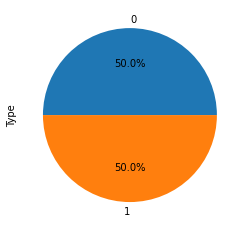

In [459]:
#get pie of the current imbalance
temp = pd.concat([X_upsampled_smote, y_upsampled_smote], axis=1)
pie_of_imbalance(temp)

After up-sampling using SMOTE's synthetic data, the dataset is perfectly in balance... however we have a Fairness problem. Can you spot what it is?

<class 'sklearn.ensemble._forest.RandomForestClassifier'>
Accuracy train: 0.8760, test:  0.7533
Precision train: 0.8963, test:  0.8450
Recall train: 0.8504, test:  0.7972
F1 train: 0.8791, test:  0.6064


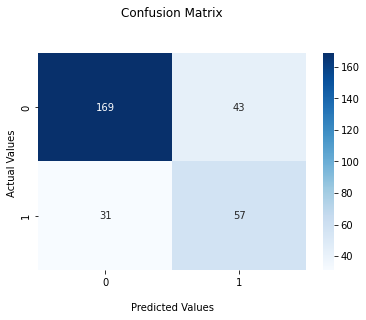

In [460]:
#Run our function....
model = run_rf_classification_models(X_upsampled_smote, X_test, y_upsampled_smote, y_test)

#### Synthetic Data's Fairness Banana Skin - Data Leakage of protected characteristics

Remember that we had two distinct groups we need to ensure fairness for, females and males? We just: generated synthetic data based off the entire dataset though - using both male and female samples - and in doing so we polluted the new rows we created with both male and female data characteristics. 
We therefore need to generate synthetic data for male rows and THEN generate synthetic data for female rows avoiding data leakage of protected characteristics.

In [461]:

from imblearn.over_sampling import SMOTE

# Generate SMOTE samples and use this to train... do for each protected class 
# separately and THEN combine.
upsampler_smote = SMOTE()


#** First add back the gender column as after the train_test_split we want to know which row is which.
#
X_gender = pd.concat([X, df_raw['gender']], axis=1)
y_gender = pd.concat([y, df_raw['gender']], axis=1)

#Split first to avoid data-snooping
X_train, X_test, y_train, y_test = train_test_split(X_gender, y_gender, test_size=0.3, random_state=None)

# GENDER: FIRST we generate synthetic samples for females, where all these synthetic 
# samples will be exclusively generated from female instances.
X_train_female = X_train[(X_train['gender'] == 'female')]
X_train_female = X_train_female.drop('gender', axis=1)
#
y_train_female = y_train[(y_train['gender'] == 'female')]
y_train_female = y_train_female.drop('gender', axis=1)

X_upsampled_smote_female, y_upsampled_smote_female = upsampler_smote.fit_resample(X=X_train_female, y=y_train_female)

#GENDER: SECOND males...where all these synethic 
# samples will be exclusively generaqted from male instances.
X_train_male = X_train[(X_train['gender'] == 'male')]
X_train_male = X_train_male.drop('gender', axis=1)
#
y_train_male = y_train[(y_train['gender'] == 'male')]
y_train_male = y_train_male.drop('gender', axis=1)

X_upsampled_smote_male, y_upsampled_smote_male = upsampler_smote.fit_resample(X=X_train_male, y=y_train_male)

#** Now remove the gender column...
X_train = X_train.drop('gender', axis=1)
y_train = y_train.drop('gender', axis=1)

# Combine male and female training data, including the SMOTE data
X_upsampled_smote = pd.concat([X_upsampled_smote_female, X_upsampled_smote_male], axis=0) # Note the axis is set to zero, so we are adding rows the bottom of the df
y_upsampled_smote = pd.concat([y_upsampled_smote_female, y_upsampled_smote_male], axis=0)

Combine the male and female upsampled data...

In [462]:
X_upsampled_smote = X_upsampled_smote_female + X_upsampled_smote_male
y_upsampled_smote = y_upsampled_smote_female + y_upsampled_smote_male

Imbalanced dataset....
1.0    137
0.0    103
2.0     32
Name: class, dtype: int64


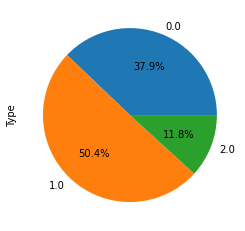

In [463]:
#get pie of the current imbalance
temp = pd.concat([X_upsampled_smote, y_upsampled_smote], axis=1)
pie_of_imbalance(temp)

### 3a iii) Down-sampling - Removing rows to balance the classes

Now we can test down-sampling, which is simply removing samples from the majority class. 

In [464]:
from imblearn.under_sampling import RandomUnderSampler 

#Split first to avoid data-snooping
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=None)

# Randomly downsample rows in the majority class
rus = RandomUnderSampler(random_state=42)
X_downsampled, y_downsampled = rus.fit_resample(X_train, y_train)

Imbalanced dataset....
0    222
1    222
Name: class, dtype: int64


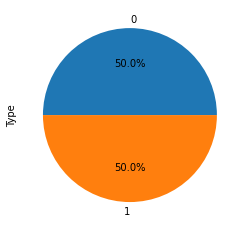

In [465]:
#get pie of the current imbalance
temp = pd.concat([X_downsampled, y_downsampled], axis=1)
pie_of_imbalance(temp)

<class 'sklearn.ensemble._forest.RandomForestClassifier'>
Accuracy train: 0.8423, test:  0.6600
Precision train: 0.8654, test:  0.8846
Recall train: 0.8108, test:  0.6216
F1 train: 0.8472, test:  0.5405


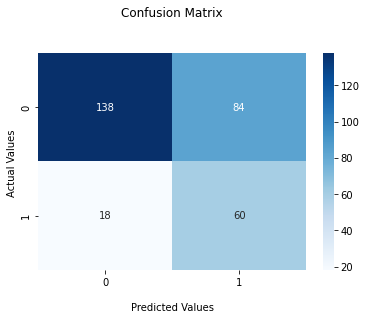

In [466]:
#Run our function....
model = run_rf_classification_models(X_downsampled, X_test, y_downsampled, y_test)

As we can see, all up and down sampling approaches have outperformed the F1 Score on the imbalanced data. The most impressive performance in this case is from up-sampling using SMOTE synthetic data.

## Stage 4b: Model Selection


Next we need to select the type of classifier we are going to use to model our problem and separate good from bad credits. We could just make a heuristic selection, but we are likely to be biased in making this selection. 

#### Bias Alert: Availability Heuristic
For instance,  is our quant team overpopulated by linear regression experts? Do we have a greater level of familiarity for Random Forest classifiers?

One way of dealing with this is to use of develop a model selection approach. We can test the problem, using many different classsifiers and assess the performance of exach based on our KPIs. However, we must be careful as even this more exhaustive approach is also open to biases. For instance if we are selection models based on p-values, we would suffer from multiplicity bias where testing multiple approaches would exaggerate the significance of a success. 

#### Bias Alert: Multiplicity bias

To control for this we would use a measure such as F1-score, and we would test this on test samples not used for training.



In [18]:
#Test and train set    
X_train_cv, X_cv, y_train_cv, y_cv = train_test_split(X_train, y_train, test_size=0.3, random_state=None)

Sklean provides many different classifiers and we will be testing a wide range to determine their accuracy on our problem.

In [19]:
from sklearn.preprocessing import StandardScaler

# Classsifiers from sklearn
from sklearn.linear_model import LogisticRegression 
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier 
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.neighbors import KNeighborsClassifier

# Performance metrics...
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

To address the availability heuristic we will now build a function that tests a number of different classifiers on our problem, and the one with the best accuracy on the cross-validation data, we will select as the "best".

DecisionTreeClassifier(max_depth=5)
F1 train: 0.8549, cross-validation:  0.4898
GaussianNB()
F1 train: 0.8198, cross-validation:  0.2769
LogisticRegression(max_iter=2000, random_state=0)
F1 train: 0.8480, cross-validation:  0.4787
MLPClassifier(early_stopping=True, max_iter=2000, random_state=1)
F1 train: 0.6925, cross-validation:  0.5359
RandomForestClassifier(max_depth=3, random_state=0)
F1 train: 0.8166, cross-validation:  0.5294
LinearDiscriminantAnalysis()
F1 train: 0.8315, cross-validation:  0.4231
QuadraticDiscriminantAnalysis()
F1 train: 0.7170, cross-validation:  0.3908
AdaBoostClassifier()
F1 train: 0.8580, cross-validation:  0.0000


/Users/madhusudhann/opt/anaconda3/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/madhusudhann/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


GradientBoostingClassifier()
F1 train: 0.9469, cross-validation:  0.0370
KNeighborsClassifier(n_neighbors=3)
F1 train: 0.8282, cross-validation:  0.0000


/Users/madhusudhann/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


SVC(C=0.025, probability=True)
F1 train: 0.3721, cross-validation:  0.0000
NuSVC(probability=True)
F1 train: 0.4348, cross-validation:  0.3908

Winner
 <class 'sklearn.neural_network._multilayer_perceptron.MLPClassifier'>
Accuracy train: 0.7632, cross-validation:  0.6619
Precision train: 0.7022, cross-validation:  0.9074
Recall train: 0.5618, cross-validation:  0.6164
F1 train: 0.6925, cross-validation:  0.5359


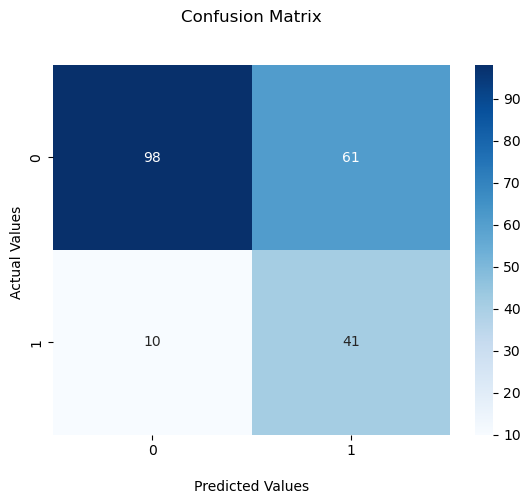

In [26]:

# Func to wrap up running these selected classification learners...
# NOTE: to test the performance of the learners out-of-sample, we should use a cross-validation dataset
# this is a hold back dataset and we will use our testing data to do this, in this case. 
def auto_classifier_selection(X_train: pd.DataFrame, 
                            X_cross_validation: pd.DataFrame, 
                            y_train: pd.DataFrame, 
                            y_cross_validation: pd.DataFrame) -> (object, list, list, list):
    
    #sanity
    if X_train.shape[0] != y_train.shape[0]:
      raise TypeError('Bad parameter: X_train.shape[0] != y_train.shape[0]')
    if X_cross_validation.shape[0] != y_cross_validation.shape[0]:
      raise TypeError('Bad parameter: X_train.shape[0] != y_train.shape[0]')
    if (X_train.dtypes != X_cross_validation.dtypes).sum() != 0:
      raise TypeError('Bad parameter: X_train.dtype != X_cross_validation.dtype')
    if (y_train.dtypes != y_cross_validation.dtypes):
      raise TypeError('Bad parameter: y_train.dtype != y_cross_validation.dtype')

    #Balance training data....
    # Generate SMOTE samples and use this to train
    upsampler_smote = SMOTE()
    X_upsampled_smote, y_upsampled_smote = upsampler_smote.fit_resample(X_train.values, y_train.values)

    sclr = StandardScaler()
    sclr.fit(X_train.values) # scale to 0 mean and std dev 1 on training data

    X_train = sclr.fit_transform(X_upsampled_smote) # scale both sets:
    X_cross_validation = sclr.fit_transform(X_cross_validation)
    
    # These are the classifiers we will select from...
    dtc = DecisionTreeClassifier(max_depth=5) #If we allow endless depth we overfit
    gnb = GaussianNB()
    lr = LogisticRegression(max_iter=2000,random_state=0)
    mlp = MLPClassifier(max_iter=2000,random_state=1, early_stopping=True) # MLP will tend to overfit unless we stop early   
    rf = RandomForestClassifier(max_depth=3,random_state=0) # << artibitrary parameters, consider hyper parameter tuning.
    lda = LinearDiscriminantAnalysis()
    qda = QuadraticDiscriminantAnalysis()
    ada = AdaBoostClassifier()
    gbc = GradientBoostingClassifier()
    knn = KNeighborsClassifier(n_neighbors=3) # << artibitrary parameters, consider hyper parameter tuning.
    svc = SVC(kernel="rbf", C=0.025, probability=True) # << artibitrary parameters, consider hyper parameter tuning.
    nsvc = NuSVC(probability=True)
    
    all_mdls = [dtc, gnb, lr, mlp, rf, lda, qda, ada, gbc, knn, svc, nsvc]
    all_mdls_desc = ['dtc', 'gnb', 'lr', 'mlp', 'rf', 'lda', 'qda', 'ada', 'gbc', 'knn', 'svc', 'nsvc']
    all_mdls_F1score = []
    
    # Loop through each classifer and record the "best"...
    max_f1 = 0
    for mdl in all_mdls:
        #Fit model
        mdl.fit(X_upsampled_smote,y_upsampled_smote)  
        y_train_hat = mdl.predict(X_upsampled_smote)
        y_cross_validation_hat = mdl.predict(X_cross_validation)       
        mdl.predict_proba(X_cross_validation)

        # Output model selection information....
        print(mdl)
        print(f"F1 train: {f1_score(y_upsampled_smote, y_train_hat, average=None)[1]:.4f}, cross-validation: ",
        f"{f1_score(y_cross_validation,y_cross_validation_hat, average=None)[1]:.4f}")
  
        # Selection based on cross-validation set, ie out of sample data not used in training
        this_cv_f1 = f1_score(y_cross_validation,y_cross_validation_hat, average=None)[1]
        if this_cv_f1 > max_f1:
            max_f1 = this_cv_f1
            max_mdl = mdl
        
        #Save the F1 score of this model...
        all_mdls_F1score.append(this_cv_f1)

    # The best....
    #Fit...
    max_mdl.fit(X_upsampled_smote,y_upsampled_smote)
    y_train_hat = max_mdl.predict(X_upsampled_smote)
    y_cross_validation_hat = max_mdl.predict(X_cross_validation)
    
    #    Print score
    print('\nWinner\n', type(max_mdl))        
    print(f"Accuracy train: {max_mdl.score(X_train,y_upsampled_smote):.4f}, cross-validation: ",
      f"{max_mdl.score(X_cross_validation,y_cross_validation):.4f}")
    print(f"Precision train: {precision_score(y_upsampled_smote, y_train_hat, average=None)[0]:.4f}, cross-validation: ",
      f"{precision_score(y_cross_validation,y_cross_validation_hat, average=None)[0]:.4f}")
    print(f"Recall train: {recall_score(y_upsampled_smote, y_train_hat, average=None)[0]:.4f}, cross-validation: ",
      f"{recall_score(y_cross_validation,y_cross_validation_hat, average=None)[0]:.4f}")
    print(f"F1 train: {f1_score(y_upsampled_smote, y_train_hat, average=None)[1]:.4f}, cross-validation: ",
      f"{f1_score(y_cross_validation,y_cross_validation_hat, average=None)[1]:.4f}")
        
    #Print confusion matrix...
    cf_matrix = confusion_matrix(y_cross_validation, y_cross_validation_hat, labels=[0, 1]) 
    cf_matrix_norm = cf_matrix.astype('float')

    ax = sns.heatmap(cf_matrix_norm, annot=True, cmap='Blues', fmt='g')
    ax.set_title('Confusion Matrix\n\n');
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ');
    plt.show()
    
    #sanity
    if max_mdl is None:
      raise TypeError('Bad return: max_mdl is None')

    return max_mdl, all_mdls, all_mdls_desc, all_mdls_F1score

# Run our function....autoselect the best classifier wrt F1
max_mdl, all_models, all_models_desc, all_mdls_F1score = auto_classifier_selection(X_train_cv, X_cv, y_train_cv, y_cv)


The output from our model selection function shows how each classifier performed on the training and cross-validation datasets. We can now test the "winning classifier" on our test data to ensure the cross-validation tests were effective in selecting a good performance out of sample.

0.4636363636363636


Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
X has feature names, but RandomForestClassifier was fitted without feature names


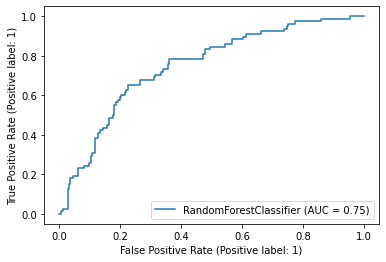

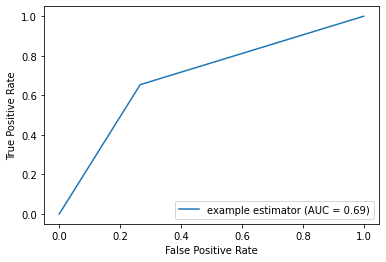

0.5425531914893617 0.4636363636363636 0.6538461538461539


In [470]:
# Predict
y_test_hat = max_mdl.predict(X_test.values)

# Analyst KPI...
f1, prec, rec = kpi_review_analyst(mdl=max_mdl,X=X_test, y=y_test[:], y_hat=y_test_hat[:])
print(f1, prec, rec)

#### Bias Alert: Inductive bias

Even in the case where we select the most appropriate model, we may still be exposed to inductive biases. Each learner has a specific way that will approximate the function we are attempting to approximate, in this cadse the function of credit quality based on the characteristics of borrowers. Decision Trees, for instance, have inductive biases associated with greedy separation, whereas Random Forests (RF) mitigate this bias by using many randomized decision trees, but in turn introduce (lesser) inductive biases associated with the way an RF's underlying decision trees are contructed. One mitigant is to ensemble different learners, using a soft-max function or a voting approach. For voting based ensembling we would simply run a number of classifiers, take the majority answer: good/bad credit. (Note that we have included 


Variables are collinear
Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
X has feature names, but LogisticRegression was fitted without feature names
X has feature names, but MLPClassifier was fitted without feature names
X has feature names, but RandomForestClassifier was fitted without feature names
X has feature names, but LinearDiscriminantAnalysis was fitted without feature names
X has feature names, but QuadraticDiscriminantAnalysis was fitted without feature names
X has feature names, but NuSVC was fitted without feature names


0.4636363636363636


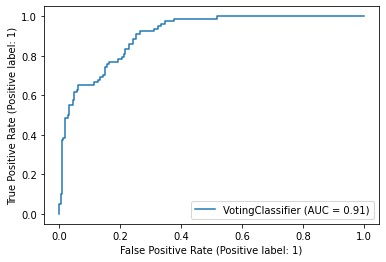

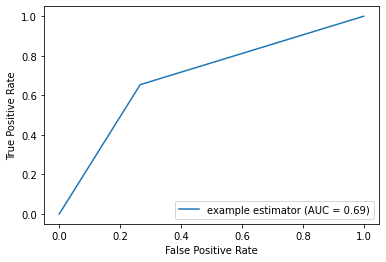

0.5425531914893617 0.4636363636363636 0.6538461538461539


In [472]:
from sklearn.ensemble import VotingClassifier

# Address model inductive biases by ensembling
def run_classifier_ensemble(all_mdls: list, 
                        all_mdls_desc: list, 
                        all_mdls_F1score: list,
                        X: np.array,
                        y: np.array) -> np.array:

  #Sanity
  if  all_mdls.__len__() != all_mdls_desc.__len__():
    raise TypeError('all_mdls.__len__() != all_mdls_desc.__len__()')
  if  all_mdls.__len__() != all_mdls_F1score.__len__():
    raise TypeError('all_mdls.__len__() != all_mdls_F1score.__len__()')
  if X.shape[0] != y.shape[0]:
    raise TypeError('X and y do not have the same length')
  
  # Only choose those models that had decent F12 score performance out of sample.
  mdls_to_ensemble =[]
  for i in range(0, all_models_desc.__len__()):
    if all_mdls_F1score[i] > np.median(all_mdls_F1score):
      mdls_to_ensemble.append((all_models_desc[i], all_models[i]))

  # Instantiate ...
  vc = VotingClassifier(estimators=mdls_to_ensemble, voting='soft')

  # Fit on the training data to train your live model... 
  ens_mdl = vc.fit(X.values, y.values)

  # Challenge! Return y_hat
  return ens_mdl


# Run the ensemble
ens_mdl = run_classifier_ensemble(all_mdls=all_models,
                        all_mdls_desc=all_models_desc,
                        all_mdls_F1score=all_mdls_F1score,
                        X=X_test,
                        y=y_test[:])

# Analyst KPI...
f1, prec, rec = kpi_review_analyst(mdl=ens_mdl,X=X_test, y=y_test[:], y_hat=y_test_hat[:])
print(f1, prec, rec)

### DRAFT!!!! FAIRNESS FUNCTIONS Removing features correlated with protected characteristics

Let us inspect the results between the "fair" model outcomes and the potentially biased....

## Stage 4c: KPI Checks - Most importantly checks for.

We noted at the outset that there was a bias between the protected characterisctis of gender, with male and female credits being different, and we removed this protected characteristic from the dataset to avoid this illegal bias in loan approval outcomes.

Protected characteristics can be picked up (proxied) in other dataitems in more subtle ways though. For instance given that single parent households tend to disproportionately be led by a female adult, this may make 'num_dependents' a proxy for gender.

It is important that we control for any possible protected biases, and one way of achieving this is to retrain our model using a mitigator, which trains by constraining the model weights to produce a balanced outcome between protected classes; male and female credits in this case.

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ 
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ 
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ 
Madhu... Fairness applied to the chosen model....
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ 
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ 
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ 

### Test For Fairness

A simple way to test for Fairness, is to train a model with a set of data without the protected classes. Then predict outcomes using the model and a set of test data, specific for each of the population group to compare if the model outputs are indeed fair across various groups. While the fairness test focus on the results, unfairness can creep in at many different stages along the way and underlying issues can be obscured. The outcomes from these tests should be used to better examine the input data and the algorithm used for its biases that cause such outcomes.

Here we assume that a RandomForestClassifier is used as the model, but that could be any model.  While the training data may not include any of the protected class variables, the test data should contain these columns.  The subsequent part of the code will filter the test data based on these population groups, run the model as many times, so that the confusion matrix metrics can be obtained for each of these population groups.

#### Measuring Fairness
In this example we will be reviewing Group Fairness - Group Fairness looks at whether a system performs similarly across different groups, such as male vs female. Any of the confusion matric metric (Precision, Recall, FDR etc) could be used to ensure that the model outcomes are not unfair to a specific population group. However, it is impossible for a model to be fair with regards to all these metrics of fairness simultaneously. So, based on the objective of the model and the consumers of the model output, picking an appropriate group fairness metric becomes important.  For example, in the case of credit approvals, the Recall measure has the most impact on consumers. 



In [40]:
#Added by Madhu
#TEST FOR FAIRNESS
#
X_all = pd.concat([X, df_raw['gender']], axis=1)
y_all = pd.concat([y, df_raw['gender']], axis=1)
X_all["age_group"] = X_all["age"].apply(lambda x: "Below 25" if x<25 else ("Above 60" if x > 60 else "25-60"))
y_all["age_group"] = X_all["age"].apply(lambda x: "Below 25" if x<25 else ("Above 60" if x > 60 else "25-60"))
#Split first 
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.3, random_state=None)
X_train = X_train.drop(['gender','age_group'],axis=1)
y_train = y_train.drop(['gender','age_group'], axis=1)
model = trainModel(X_train, y_train.values.ravel())

#### Accuracy vs Fairness

For classifiers such as this model, any model result past a predefined threshold would be considered an approval, n below the threshold would be a rejection of the credit application.  By adjusting the threshold values, the false positive / false negative outputs from the model can be managed.  One exercise to ensure fair models is to appropriately design a threshold value such that the model is most accurate and also most fair to all underlying population groups. It is normally seen that there is a trade-off between accuracy and fairness when using machine learning models to make policy decisions.

The below code plots the Recall, Precision and FDR values from the test outputs, for different population groups: gender(**Male**/Female) and Age Group (Below 25/**25-60**/Above 60 age groups. In a fair model, each of the population group should not be more than 20% worse-off than the **majority** group. The plots display the range as between the two red lines. Any population group with a metric value outside the range between the red lines is impacted negatively by the model.  Adjusting the model parameters or 

Higher the recall values, the lower is the False Negatives.  Higher the precision values, the lower is False Positives.  A judgement call is neeeded to confirm if the false positives have more adverse impact or false negatives.  In case of credit approval process, for a loan applicant, false negatives should be minimized.  So recall is the more appropriate measure.

In [60]:
#Added by Madhu
fairnessTestItems = ["gender", "age_group"]
majorityCategories = ["male", "25-60"]
compareMetrics = ["Recall", "Precision"]

First we test for Fairness at a threshld of 0.8. The model metrics are all within range, however the model precision can be improved

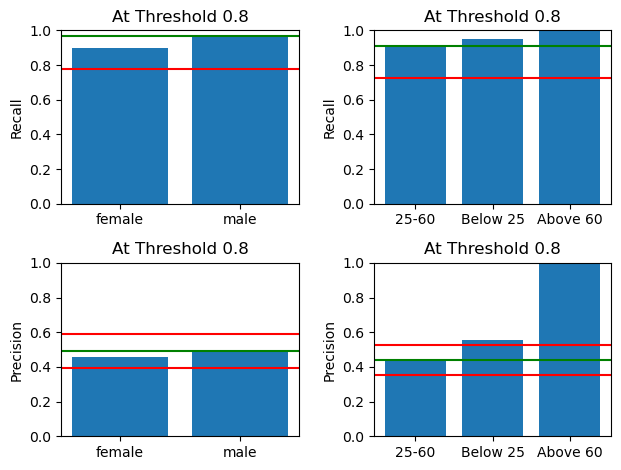

In [61]:
#Added by Madhu
threshold = 0.8
testForFairness(max_mdl, fairnessTestItems, majorityCategories, compareMetrics, threshold)


/var/folders/vt/y0s__sfn49j5x0l03d9y4ff80000gn/T/ipykernel_1050/3235079143.py:23: RuntimeWarning: invalid value encountered in long_scalars
  npv = TN/(TN+FN)


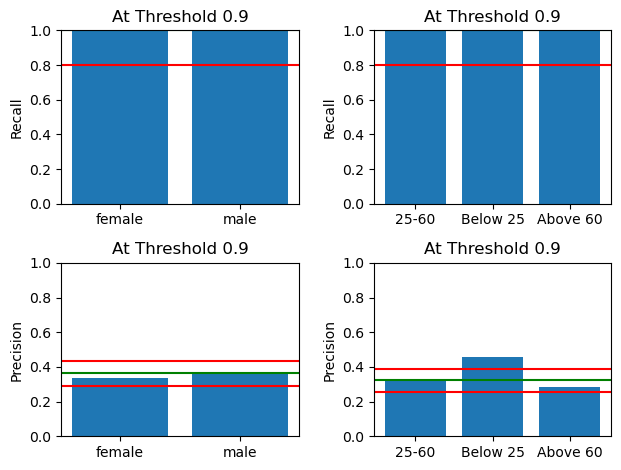

In [62]:
threshold = 0.9
testForFairness(max_mdl, fairnessTestItems, majorityCategories, compareMetrics, threshold)

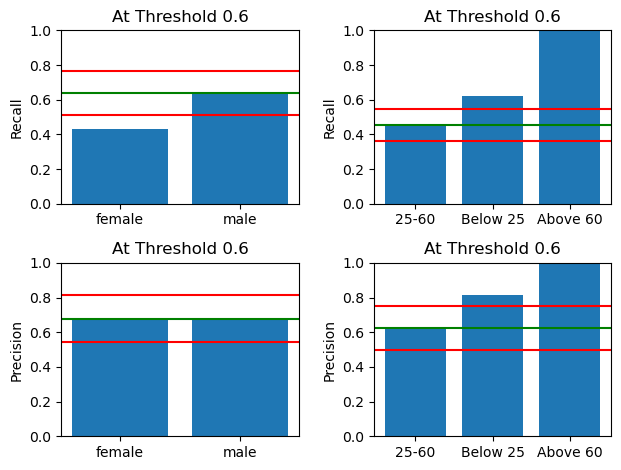

In [63]:
threshold = 0.6
testForFairness(max_mdl, fairnessTestItems, majorityCategories, compareMetrics, threshold)

The balance almost equal, this indicates that our model is tending to show now bias based non gender, which indicates that removing the protected dataitem in thefirst place has had a balancing effect on the outcomes. 

However, we can still explicuitly remove correlated features, and constrain model training to remove bias.

# Stage4: Model Deployment 

Model deployment generally involves a change process, several levels of testing and sign off, asignment of responsibilities for the live operation of the process, models and data before deployiong the code to the cloud (or on native hardware). 
A key part of thius stage is communication of the KPIs to stakleholders to enable them to understand the way the models operate, the risks involved and to be accountable for deploying the models


## Communication: Stakeholder Oriented Explanations

Communication of how the model has reached the outcomes it is has, is crutial to achieve fairness, transparency, accountability, and trust in the whole process. Each stakeholder in the process needs to see different elements. The Data Scientist and technical leadership need to review the nut and bolts of the model, reviewing residuals plots, parameter importance, interaction terms and many other metrics. The customer needs to see far less information, and mainly that associated with a refusal of credit. Compliance resources and regulators need to see something different again, such as fairness regarding protected characteristics, the accuracy and therefore capital risk represented by the models. 
In this section we look at stakeholder oriented explanations and we will be using standard charts of important analytics, such as residual plots, and SHAP.

First let us get the packages we will need...

In [518]:
pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [519]:
import shap

Now instantiate the SHAP explainer object for our classifier and generate Shapley values for the test data... Note that as we will be using the test data, all the analysis is therefore based on the out of sample performance of our model.

In [578]:
print(type(max_mdl).__name__)

# Instantiate an explainer object for our chosen classifier...
if type(max_mdl).__name__ == 'DecisionTreeClassifier':
  explainer = shap.Explainer(max_mdl.predict, X_test.values)
  shap_values = explainer(X_test.values)
elif type(max_mdl).__name__ == 'GaussianNB':
  explainer = shap.KernelExplainer(max_mdl.predict, X_test.values)
  shap_values = explainer.shap_values(X_test.values)
elif type(max_mdl).__name__ == 'LogisticRegression':
  masker=shap.maskers.Impute(data=X_test) #,feature_names=X_test.columns)
  explainer = shap.LinearExplainer(max_mdl, masker = masker)  
  shap_values = explainer.shap_values(X_test.values)
elif type(max_mdl).__name__ == 'MLPClassifier':
  explainer = shap.KernelExplainer(max_mdl.predict, X_test.values)
  shap_values = explainer.shap_values(X_test.values)
elif type(max_mdl).__name__ == 'RandomForestClassifier':
  explainer = shap.Explainer(max_mdl.predict, X_test.values)
  shap_values = explainer(X_test.values)
elif type(max_mdl).__name__ == 'LinearDiscriminantAnalysis':
  masker = shap.maskers.Independent(data = X_test.values)
  explainer = shap.LinearExplainer(max_mdl, masker = masker)
  shap_values = explainer(X_test.values)
elif type(max_mdl).__name__ == 'QuadraticDiscriminantAnalysis':
  explainer = shap.Explainer(max_mdl.predict, X_test.values)
  shap_values = explainer(X_test.values)
elif type(max_mdl).__name__ == 'AdaBoostClassifier':
  explainer = shap.Explainer(max_mdl.predict, X_test.values)
  shap_values = explainer(X_test.values)
elif type(max_mdl).__name__ == 'GradientBoostingClassifier':
  explainer = shap.Explainer(max_mdl.predict, X_test.values)
  shap_values = explainer(X_test.values)
elif type(max_mdl).__name__ == 'KNeighborsClassifier':
  explainer = shap.Explainer(max_mdl.predict, X_test.values)
  shap_values = explainer(X_test.values)
elif type(max_mdl).__name__ == 'SVC':
  explainer = shap.Explainer(max_mdl.predict, X_test.values)
  shap_values = explainer(X_test.values)
elif type(max_mdl).__name__ == 'NuSVC':
  explainer = shap.Explainer(max_mdl.predict, X_test.values)
  shap_values = explainer(X_test.values)

# Get the Shapley values for the X_test data...
#shap_values = explainer.shap_values(X_test.values)

IndexError: ignored

### 1) Analyst and technical explainability

0.4636363636363636


Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
X has feature names, but RandomForestClassifier was fitted without feature names


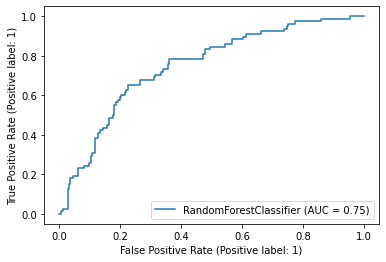

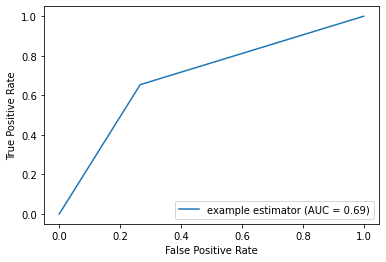

(0.5425531914893617, 0.4636363636363636, 0.6538461538461539)

In [525]:
# Analyst KPI...
kpi_review_analyst(mdl=max_mdl,X=X_test, y=y_test, y_hat=y_test_hat)

In [526]:
X_test

,duration,credit_amount,installment_commitment,residence_since,age,existing_credits,num_dependents,foreign_worker,checking_status_0<=X<200,checking_status_<0,...,other_payment_plans_stores,housing_for free,housing_own,housing_rent,job_high qualif/self emp/mgmt,job_skilled,job_unemp/unskilled non res,job_unskilled resident,own_telephone_none,own_telephone_yes
885,12,795,4,4,53,1,1,1,0,1,...,0,0,1,0,0,1,0,0,1,0
864,10,2210,2,2,25,1,1,1,0,0,...,0,0,0,1,0,0,0,1,1,0
575,15,2788,2,3,0,2,1,1,0,0,...,0,0,1,0,0,1,0,0,1,0
778,36,5711,4,2,38,2,1,1,0,0,...,0,0,1,0,1,0,0,0,0,1
979,15,1264,2,2,25,1,1,1,1,0,...,0,0,0,1,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
440,12,1884,4,4,39,1,1,1,0,0,...,0,0,1,0,1,0,0,0,0,1
256,24,2684,4,2,35,2,1,1,0,0,...,0,0,1,0,0,0,0,1,1,0
319,15,3643,1,4,27,2,1,1,0,1,...,0,0,1,0,0,0,0,1,1,0
181,36,4455,2,2,30,2,1,1,1,0,...,1,0,1,0,1,0,0,0,0,1


Feature importance

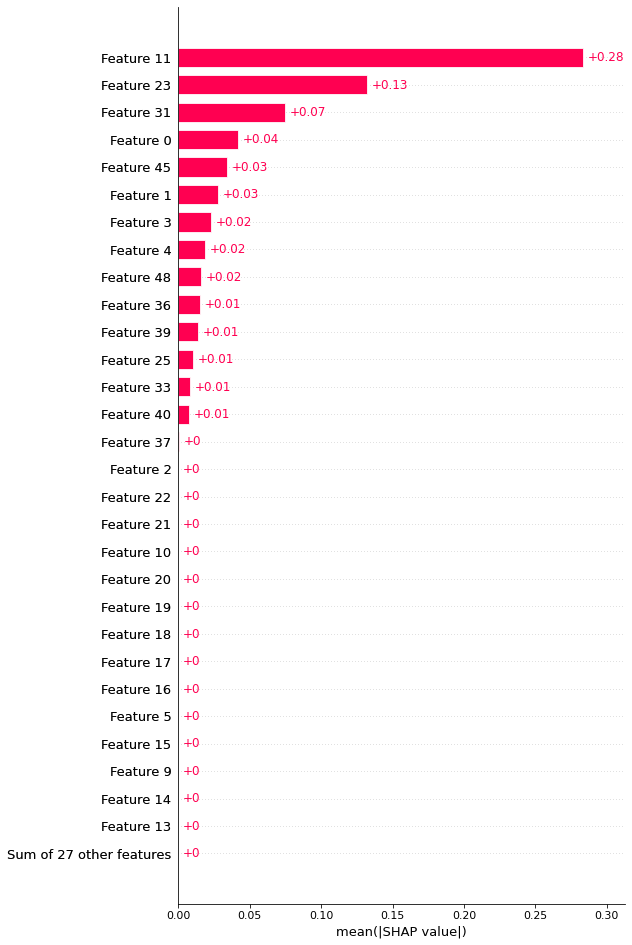

In [552]:
# Plot the feature importance
shap.plots.bar(shap_values, max_display=30)

### 2) Compliance and Regulatory



See if any features are suspiciously important for one gender vs another.

In [30]:
X_test['gender']

352    female
279    female
218    female
681    female
581    female
        ...  
434    female
718    female
698    female
983    female
435    female
Name: gender, Length: 300, dtype: object

In [31]:
# Parameter importance by gender..
gdr = ["male" if x==1 else "female" for x in X_test['gender']]

# Plot the feature importance
shap.plots.bar(shap_values.cohorts(gdr).abs.mean(0))

NameError: name 'shap' is not defined

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ 
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ 
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ 
Madhu
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ 
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ 
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ 

### 3) Customer

A customer may want to knowlt he sensitivity of the decision to certain characteristics. IF a refusal has been made, it would be beneficial to report to the customer what they need to change to get a favorable outcome. 

We can use the SHAP waterfall plot to help

In [ ]:
# Find a customer with bad credit prediction
for rejected_eg_rowno in range(0,y_test.shape[0]):
  if y_test.iloc[rejected_eg_rowno] == 1:
    break

# This customer was refused credit and we can provide an explanation for their refusal...
shap.plots.waterfall(shap_values[rejected_eg_rowno])

In [ ]:
y_test.reset_index()

# Stage 5: Model Monitoring and Reporting

Our model is now in production and being used in practice. We are "risk on" and we need to continually monitor and record our KPIs. Individuals accountability for these processes is critical.

We also need to monitor data drift. If the distribution or the nature of the data we pass into our model substantioally differs from our training data, our model results will almost certainly be garbage. We need to monitor data drift and should drift occurr we need to re-run our model developmnent process to traing an appropriate model. This would take us back to Stage2 in this process.

There is also the question of whether our model is still the best approach as time steps forward? Our model paramaters may become stale, the model itself may be less appropriaytr given its inductive biases. Many things can change and to monitor this we should consider using a challenger model. Challenger models are used to compete against our live model, and we should monitor our KPIs generated by our live model and compare them to those produced by the challenger model. 

## Stage5a: Data Drift

In [ ]:
# AUGUSTINE! Add your function call HERE

## Stage5b: Challenger Models

So what model do we use as a challenger, and when do we traing it? There are no perfect answers but we can use our model development pipeline to help. Note that our model selection function, auto_classifier_selection, allowed us to generate a range of classifiers, we can use one or all of these classifiers as our challenger. If we decided to ensemble the classifiers as our live model (ir combine the results of all in a voting ensemble for instance) we can select the best single model as our challeger. If we decided to use the best single model as our live model, we can use a boting ensemble as our challenger.



In [ ]:
from sklearn.ensemble import VotingClassifier

# Prepare our models for ensembling
challenger_models = []
for i in range(0, all_models_desc.__len__()):
  challenger_models.append((all_models_desc[i], all_models[i]))


# Instantiate ...
vc = VotingClassifier(estimators=challenger_models, voting='hard')

# Fit on the training data to train your live model... 
challenger_mdl = vc.fit(X, y)

# Challenge! Compare the results
challenger_mdl.predict(X)